In [1]:
'''
Results from the thesis
-----------------------

This script takes input data from a classification task experiment, and
runs a series of analyses on it, from pre-processing to interpretations.

Here is the overall structure that the analyses follow:
 - importing the data, preprocessing it
 - checking for the effects of masking, occluder size, difficulty
 - establishing the role of recurrence by correlating masking effect and
   RT
 - once these effects are established, pushing further with PCA plots
 - going deeper into the occluder size effect: why is it happening?
   -> black pixel count
   -> aperture count
'''


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from sklearn.decomposition import PCA
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
import pingouin as pg
import scikit_posthocs as sp
from scipy.stats import boxcox
import statsmodels.api as sm 
import cv2 as cv
import warnings
from scipy.stats import rankdata
warnings.filterwarnings("ignore")


# import style sheet
plt.style.use(r"../Analysis/styles/mystyle.mplstyle")

# list the data files
data_files = glob.glob(r'../Experiment/data/results*.csv')

# read the data files into a single dataframe
df = pd.concat([pd.read_csv(file) for file in data_files])


### Filter out the data

# select only the main task
df = df.loc[df['task']=='experiment']

# select out the columns
columns_to_keep = ['pt_num', 'trial_nbr', 'block_number', 'rt', 'soa', 'acc', 'category', 'choiced_category',
                   'difficulty', 'size_occl', 'filename','pressed_key', 'correct_key']
# keep only the relevant columns
df = df[columns_to_keep]

#rename the columns
df.rename(columns={'choiced_category': 'chosen_category'}, inplace=True)


# reset the index
df.reset_index(drop=True, inplace=True)

# remove the nan answers
df = df.loc[df['pressed_key']!='NAN']


### Remove outliers

# make a histogram of participants average accuracy
# from there we decide that the cut will be at 0.7

# list outlier participants with averagea ccuracy below 0.7
outlier_ppts = [p for p in df['pt_num'].unique() if df.loc[df['pt_num']==p, 'acc'].mean() < 0.7]
# remove them from the data
df = df.loc[~df['pt_num'].isin(outlier_ppts)]

# make a histogram of trial RTs
# from there we decide of the cutoff quantile

# list the trials with RT above the 99th quantile
ninty_ninth = df["rt"].quantile(0.99)
# drop the trials with RT above this value
df = df.loc[df['rt']<ninty_ninth]

# list the trials with RT below the 0.001th quantile
zero_point_first_quantile = df['rt'].quantile(0.001)
df = df.loc[df['rt']>zero_point_first_quantile]

## RT

SpherResults(spher=True, W=3003.61397672277, chi2=-216.2044305415396, dof=2, pval=1.0)

ANOVA SUMMARY

Source              SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr    ng2    eps
---------------  -----  -------  -------  -----  ------  -------  -----------  -----  -----
size_occl        0.042        1       28  0.042  40.891    0.000        0.000  0.012  1.000
soa              0.010        2       56  0.005   7.312    0.002        0.003  0.003  0.844
size_occl * soa  0.001        2       56  0.001   1.277    0.287        0.283  0.000  0.796

  0.1    0.05    0.025
-----  ------  -------
1.000   0.000    0.004
0.000   1.000    1.000
0.004   1.000    1.000

  few large    many small
-----------  ------------
      1.000         0.000
      0.000         1.000



Text(0.5, 1.0, 'Occluder size Comparison')

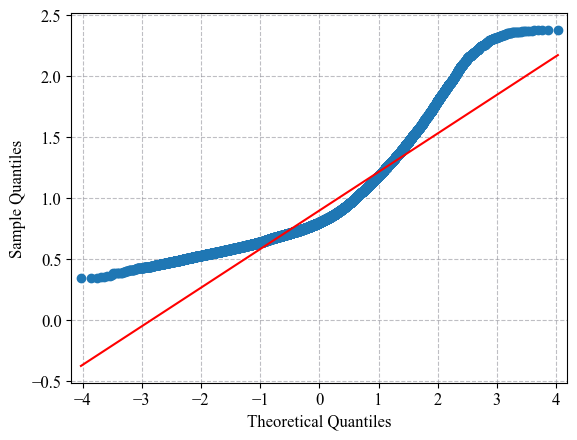

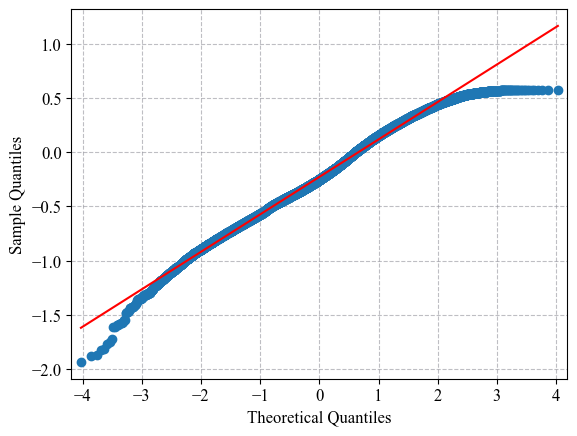

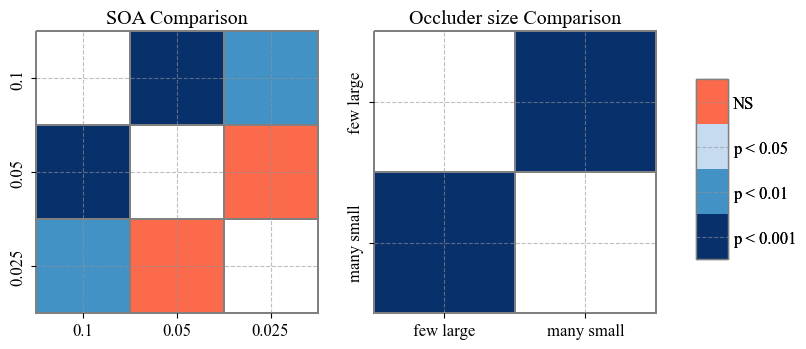

In [2]:
### ANOVAs


## Main ANOVA: occluder size x masking SOA

# assumption checks: normality is violated (include the test results)
# include the results from the rank-transformed analysis, which are similar

# Perform Visual QQ-plot to check for normality
sm.qqplot(df[df['acc']]['rt'],line='s')

#Normality Assumption is violated, therefore we transform our data with boxcox method using lambda = -1, meaning logarithmic transformation
df['cox_rt'] = boxcox(df['rt'], lmbda=-1)
sm.qqplot(df[df['acc']]['cox_rt'], line='s')

# We will be using the boxcox_rt for the ANOVA


# For sphericity, we use Mauchly's test
print(pg.sphericity(df[df['acc']], dv='rt', within=['size_occl', 'soa'], subject='pt_num'))
# Sphericity Assumption is not violated



# main ANOVA on RT
main_result = pg.rm_anova(data=df[df['acc']], dv='cox_rt', within=['size_occl', 'soa'], subject= 'pt_num', detailed=True)
pg.print_table(main_result)

# post hoc on RT - SOA
posthoc_soa = sp.posthoc_ttest(df[df['acc']], val_col= "cox_rt", group_col= "soa", p_adjust='bonferroni')

# post hoc on RT - occluder size
posthoc_size_occl = sp.posthoc_ttest(df[df['acc']], val_col= "cox_rt", group_col= "size_occl", p_adjust='bonferroni')

pg.print_table(posthoc_soa)
pg.print_table(posthoc_size_occl)
# ...

# Create the heatmap with significance stars
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
cmap = ['1', '#fb6a4a', '#08306b', '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax=ax[0])
sp.sign_plot(posthoc_size_occl, **heatmap_args, ax=ax[1])
ax[0].set_title('SOA Comparison')
ax[1].set_title('Occluder size Comparison')

# ...
# here you add posthoc comparison graphs
# these graphs show the main effect of occluder size and SOA on RT
# with potential pairwise significant differences (make pointplots with
# significance stars)

# because there is no interaction effect, we don't dig deeper into sub-anovas
# somehow we need to check for the effects of difficulty, we need to think
# about that …

### Plot Trials

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

few large_0.1 v.s. many small_0.1: Custom statistical test, P_val:5.000e-02
few large_0.025 v.s. many small_0.025: Custom statistical test, P_val:5.000e-02
few large_0.05 v.s. many small_0.05: Custom statistical test, P_val:5.000e-02


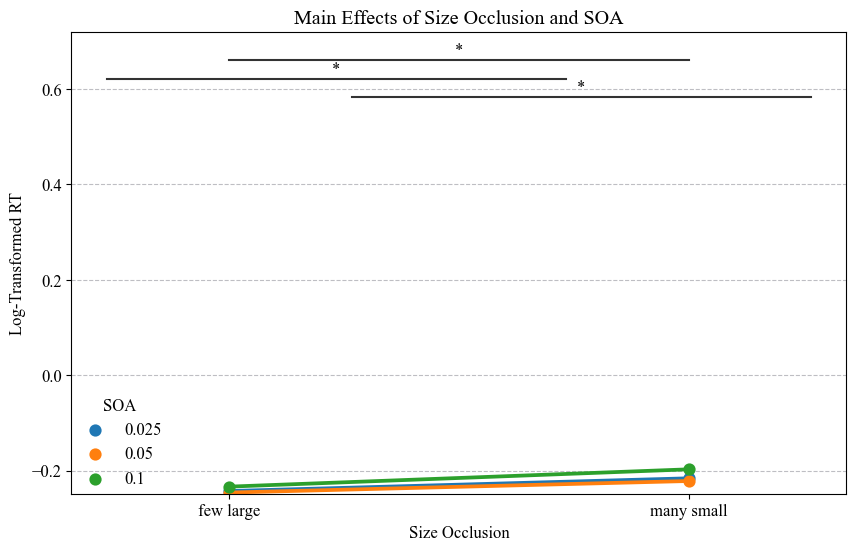

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from statannot import add_stat_annotation

# Repeated measures ANOVA
main_result = pg.rm_anova(data=df[df['acc']], dv='cox_rt', within=['size_occl', 'soa'], subject='pt_num', detailed=True)

# Main effects plot with hue
plt.figure(figsize=(10, 6))
ax = sns.pointplot(data=df[df['acc']], x='size_occl', y='cox_rt', hue='soa', ci=None)

plt.title('Main Effects of Size Occlusion and SOA')
plt.xlabel('Size Occlusion')
plt.ylabel('Log-Transformed RT')
plt.legend(title='SOA')

# Add significance stars
# Example p-values for the comparison ('A', 'B')
p_values = [0.05, 0.05, 0.05]  # Adjust the p-values according to your results
box_pairs = [(('many small', 0.025), ('few large', 0.025)),
             (('many small', 0.05), ('few large', 0.05)),
             (('many small', 0.1), ('few large', 0.1))]
add_stat_annotation(ax=ax, data=df[df['acc']], x='size_occl', y='cox_rt', hue='soa', box_pairs=box_pairs, perform_stat_test=False,
                    pvalues=p_values, loc='inside')

plt.show()

## Accuracy

In [4]:


# main ANOVA on accuracy
# make a grouped dataframe with average accuracy per subject and per condition
aov_acc_df = df.groupby(['pt_num', 'size_occl', 'soa'], as_index=False)['acc'].mean()

# Assumption Checks
# Doing participant based Normality check
acc_aggregate = []
for i in range(30):
    if i == 14:
        continue
    # Because we removed the participant 15, we need to skip it
    df_temp = aov_acc_df[(aov_acc_df['pt_num'] == (i+1))]
    acc_aggregate.append((np.mean(df_temp['acc'])))
print(pg.normality(acc_aggregate))

# Normality Assumption Holds

# For sphericity, we use Mauchly's test
print(pg.sphericity(aov_acc_df, dv='acc', within=['size_occl', 'soa'], subject='pt_num'))

# Both Sphericity and Normality Assumptions hold, we can proceed with the ANOVA

# run the anova
aov_acc = pg.rm_anova(data=aov_acc_df, dv='acc', within=["size_occl", 'soa'], subject = "pt_num", detailed = True)
pg.print_table(aov_acc)

## Anova shows interaction effect, therefore post hoc tests are not justified to have a look at the main effects

# post hoc on accuracy - SOA
#posthoc_soa = sp.posthoc_ttest(aov_acc_df, val_col= "acc", group_col= "soa", p_adjust='bonferroni')

# post hoc on accuracy - occluder size
#posthoc_size_occl = sp.posthoc_ttest(aov_acc_df, val_col= "acc", group_col= "size_occl", p_adjust='bonferroni')

          W      pval  normal
0  0.966193  0.461623    True
SpherResults(spher=True, W=inf, chi2=-inf, dof=2, pval=1.0)

ANOVA SUMMARY

Source              SS    ddof1    ddof2     MS        F    p-unc    p-GG-corr    ng2    eps
---------------  -----  -------  -------  -----  -------  -------  -----------  -----  -----
size_occl        0.431        1       28  0.431  224.239    0.000        0.000  0.595  1.000
soa              0.136        2       56  0.068  149.228    0.000        0.000  0.316  0.927
size_occl * soa  0.024        2       56  0.012   35.985    0.000        0.000  0.077  0.925



### Sub-Anovas per occluder size

          W      pval  normal
0  0.961041  0.348635    True

ANOVA SUMMARY

Source               SS    ddof1    ddof2     MS        F    p-unc    p-GG-corr    ng2    eps
----------------  -----  -------  -------  -----  -------  -------  -----------  -----  -----
soa               0.419        2       56  0.209  141.185    0.000        0.000  0.271  0.990
difficulty        3.433        2       56  1.716  281.539    0.000        0.000  0.753  0.670
soa * difficulty  0.161        4      112  0.040   42.241    0.000        0.000  0.125  0.358

SOA
          0.025     0.050     0.100
0.025  1.000000  0.044566  0.000015
0.050  0.044566  1.000000  0.059172
0.100  0.000015  0.059172  1.000000
Difficulty
              control          high           low
control  1.000000e+00  3.224941e-54  9.444031e-28
high     3.224941e-54  1.000000e+00  1.884489e-19
low      9.444031e-28  1.884489e-19  1.000000e+00
          W     pval  normal
0  0.974193  0.67753    True

ANOVA SUMMARY

Source              

Text(0.5, 1.0, 'Difficulty Comparison')

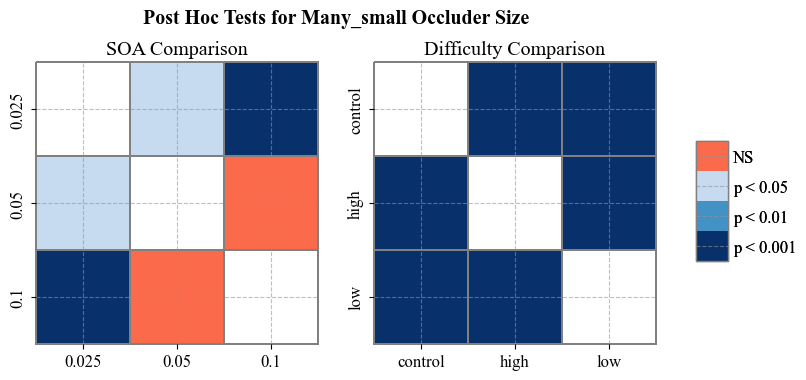

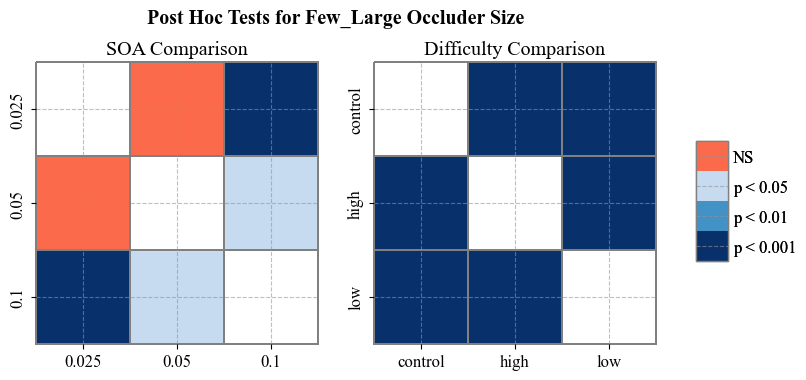

In [18]:
# Now we need to dig deeper into the occluder size effect

## Small occluder size ANOVA
so_df = df.loc[df['size_occl']=='many small']
so_df_acc = so_df.groupby(['pt_num', 'soa', 'difficulty'], as_index=False)['acc'].mean()

# Assumption Checks
acc_aggregate = []
for i in range(30):
    if i == 14:
        continue
    # Because we removed the participant 15, we need to skip it
    df_temp = so_df_acc[(so_df_acc['pt_num'] == (i+1))]
    acc_aggregate.append((np.mean(df_temp['acc'])))
print(pg.normality(acc_aggregate))
# Normality Assumption Holds

# For sphericity, we use Mauchly's test
# yet, 2 factors with 3 levels each, sphericity test is not supported, therefore please check R file for the sphericity test.
# This results in a violation of the sphericity assumption on difficulty and interaction, therefore we will use the Greenhouse-Geisser correction
so_acc_anova = pg.rm_anova(data=so_df_acc, dv='acc', within=["soa", 'difficulty'], subject = "pt_num", detailed = True)
pg.print_table(so_acc_anova)
# All main effects are significant, and there is a interaction effect between SOA and difficulty

posthoc_soa = sp.posthoc_ttest(so_df_acc, val_col= "acc", group_col= "soa", p_adjust='bonferroni')
print("SOA")
print(posthoc_soa)

# post hoc on accuracy - difficulty
posthoc_diff = sp.posthoc_ttest(so_df_acc, val_col= "acc", group_col= "difficulty", p_adjust='bonferroni')
print("Difficulty")
print(posthoc_diff)

# Create the heatmap with significance stars
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
cmap = ['1', '#fb6a4a', '#08306b', '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax=ax[0])
sp.sign_plot(posthoc_diff, **heatmap_args, ax=ax[1])
plt.suptitle('Post Hoc Tests for Many_small Occluder Size')
ax[0].set_title('SOA Comparison')
ax[1].set_title('Difficulty Comparison')


###############################################################################################################################3

## Large occluder size ANOVA
lo_df = df.loc[df['size_occl']=='few large']
lo_df_acc = lo_df.groupby(['pt_num', 'soa', 'difficulty'], as_index=False)['acc'].mean()

# Assumption Checks
acc_aggregate = []
for i in range(30):
    if i == 14:
        continue
    # Because we removed the participant 15, we need to skip it
    df_temp = lo_df_acc[(lo_df_acc['pt_num'] == (i+1))]
    acc_aggregate.append((np.mean(df_temp['acc'])))
print(pg.normality(acc_aggregate))
# Normality Assumption Holds

# For sphericity, we use Mauchly's test
# yet, 2 factors with 3 levels each, sphericity test is not supported, therefore please check R file for the sphericity test.
# This results in a violation of the sphericity assumption on difficulty, therefore we will use the Greenhouse-Geisser correction
lo_acc_anova = pg.rm_anova(data=lo_df_acc, dv='acc', within=["soa", 'difficulty'], subject = "pt_num", detailed = True)
pg.print_table(lo_acc_anova)
# All main effects are significant, and there is a interaction effect between SOA and difficulty

## Optional Post Hoc Tests
# post hoc on accuracy - SOA
posthoc_soa = sp.posthoc_ttest(lo_df_acc, val_col= "acc", group_col= "soa", p_adjust='bonferroni')
print("SOA")
print(posthoc_soa)

# post hoc on accuracy - difficulty
posthoc_diff = sp.posthoc_ttest(lo_df_acc, val_col= "acc", group_col= "difficulty", p_adjust='bonferroni')
print("Difficulty")
print(posthoc_diff)

# Create the heatmap with significance stars
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
cmap = ['1', '#fb6a4a', '#08306b', '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax=ax[0])
sp.sign_plot(posthoc_diff, **heatmap_args, ax=ax[1])
plt.suptitle('Post Hoc Tests for Few_Large Occluder Size')
ax[0].set_title('SOA Comparison')
ax[1].set_title('Difficulty Comparison')

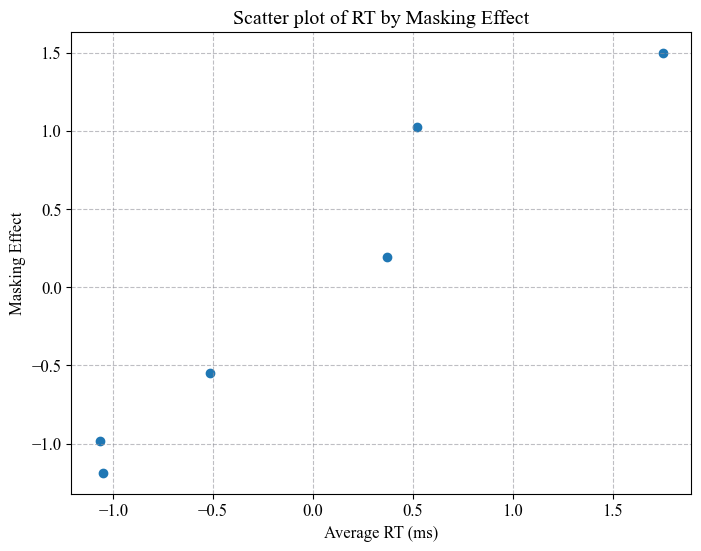

In [ ]:


### Correlating masking effect x RT

# list the tasks and their display names
tasks = {
    'many small_control': 'MS control',
    'many small_low': 'MS low',
    'many small_high': 'MS high',
    'few large_control': 'FL control',
    'few large_low': 'FL low',
    'few large_high': 'FL high'
}
# make a task column
df['task'] = df['size_occl'] + '_' + df['difficulty']
# find out the masking effect and average RT per task
mask_rt_df = pd.DataFrame({
    'task' : [t for t in tasks],
    'masking effect': [np.mean(df.loc[(df['task']==t) & (df['soa']==0.1), 'acc']) - 
                       np.mean(df.loc[(df['task']==t) & (df['soa']==0.025), 'acc']) 
                       for t in tasks],
    'RT' : [np.mean(df.loc[(df['task']==t), 'rt']) for t in tasks]
})
# make a standardised version of the data using x = (x-m)/s
std_mask_rt_df = pd.DataFrame()
for col in ['RT', 'masking effect']:
    std_mask_rt_df[col] = ( mask_rt_df[col] - np.mean(mask_rt_df[col]) ) / np.std(mask_rt_df[col])
std_mask_rt_df['task'] = mask_rt_df['task']
# correlate the results
corr, p_value = pearsonr(mask_rt_df['RT'].values, mask_rt_df['masking effect'].values)

# make a scatterplot of RT x masking effect
plt.figure(figsize=(8, 6))
plt.scatter(std_mask_rt_df['RT'], std_mask_rt_df['masking effect'])
plt.xlabel('Average RT (ms)')
plt.ylabel('Masking Effect')
plt.title('Scatter plot of RT by Masking Effect')
plt.show()


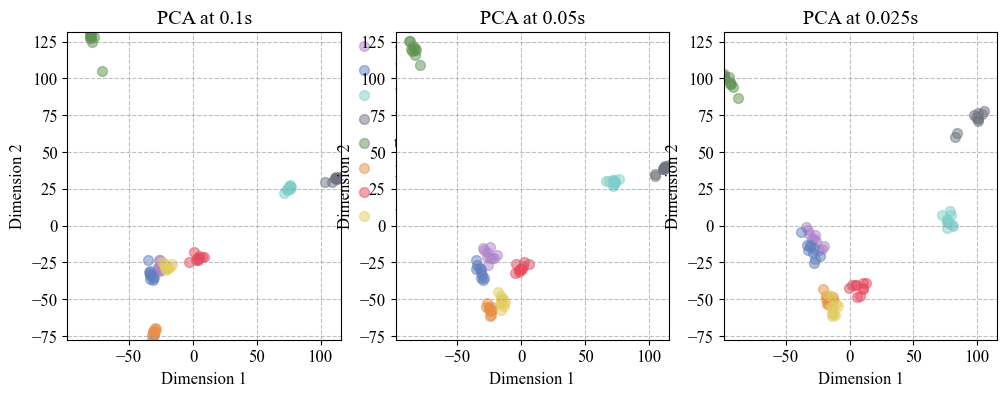

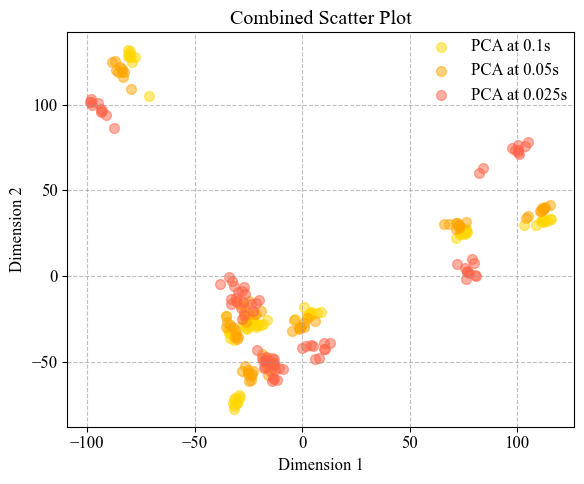

In [ ]:
### Category-based analyses

# build a dictionary with category-level confusion matrices
# this is not super useful actually
confmat_dict = {
    size_occl: {soa:
        confusion_matrix(
            y_pred = df.loc[(df['size_occl']==size_occl)&(df['soa']==soa),'chosen_category'],
            y_true = df.loc[(df['size_occl']==size_occl)&(df['soa']==soa),'category'],
            labels = df['category'].unique()
        )
        for soa in df['soa'].unique()}
    for size_occl in df['size_occl'].unique()
}




### Image-based analyses

## build image-wise confusion dataframe per soa

# add an image column
df['image'] = [str(Path(i).stem).split('_')[-1] for i in df['filename']]
# list all the individual images
im_labels = df['image'].unique()
# build the image-wise confusion dictionary per soa
im_cm_dict = {
    soa: {
        c: [ len(df.loc[(df['image']==im)&(df['chosen_category']==c)&(df['soa']==soa)])
            for im in im_labels ]
        for c in df['category'].unique()
    }
    for soa in df['soa'].unique()
}
# build the PCA from there
im_pca_dict = {
    soa: pd.DataFrame(
        {
            'Image': im_labels,
            'Category': pd.Series(im_labels).replace({ # adding a category column
            (fr'^{c}\w+'): c for c in df['category'].unique()
            }, regex = True),
            'Dimension 1': PCA(n_components=2).fit_transform(pd.DataFrame(im_cm_dict[soa]))[:,0],
            'Dimension 2': PCA(n_components=2).fit_transform(pd.DataFrame(im_cm_dict[soa]))[:,1]
        }
    )
    for soa in df['soa'].unique()
}

## Plot the results on three successive plots
# choose category colours
category_palette = {
    "person": "#E78F46",
    "cat": "#AF83CB",
    "bird": "#6080BD",
    "tree": "#609550",
    "banana": "#E2CD61",
    "firehydrant": "#E74A5F",
    "bus": "#7ECEC9",
    "building": "#6F747F"
}

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as needed

# Calculate the limits for consistent axes scaling
xmin, xmax, ymin, ymax = float('inf'), float('-inf'), float('inf'), float('-inf')
for df in im_pca_dict.values():
    xmin = min(xmin, df['Dimension 1'].min())
    xmax = max(xmax, df['Dimension 1'].max())
    ymin = min(ymin, df['Dimension 2'].min())
    ymax = max(ymax, df['Dimension 2'].max())

# Plotting each DataFrame in a subplot
for i, (key, df) in enumerate(im_pca_dict.items()):
    ax = axs[i]
    categories = df['Category'].unique()
    
    # Plotting each category separately with custom colors
    for cat in categories:
        cat_data = df[df['Category'] == cat]
        ax.scatter(
            cat_data['Dimension 1'],
            cat_data['Dimension 2'],
            label=cat,
            color=category_palette[cat],
            s=50,
            alpha=0.5
        )
    
    ax.set_title(f'PCA at {key}s')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_xlim(xmin, xmax)  # Constrain X-axis to same values
    ax.set_ylim(ymin, ymax)  # Constrain Y-axis to same values
    
    if key == 0.1:
        ax.legend(bbox_to_anchor=(1.0, 1.0))  # Show legend only for the last plot

plt.show()


## Plot the results on one single plot, overlapping
# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.concat(im_pca_dict.values(), keys=im_pca_dict.keys())

# Create a scatter plot with distinct colors for each DataFrame
plt.figure(figsize=(6, 5))  # Adjust figsize as needed

for (key, df), color in zip(im_pca_dict.items(), ['gold', 'orange', 'tomato']):
    df = df.reset_index(drop=True)  # Reset index for each DataFrame
    plt.scatter(df['Dimension 1'], df['Dimension 2'], label=f'PCA at {key}s', s=50,color=color, alpha=0.5)

plt.title('Combined Scatter Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.legend()
plt.show()



# the last plots show nicely how masking affect representations and how these
# get more isolate (categories clustering and increasing space with others)
# across time. this being demonstrated, we go deeper into the occluder size
# differences

# we now go deeper into trying to explain the difference between occluder sizes


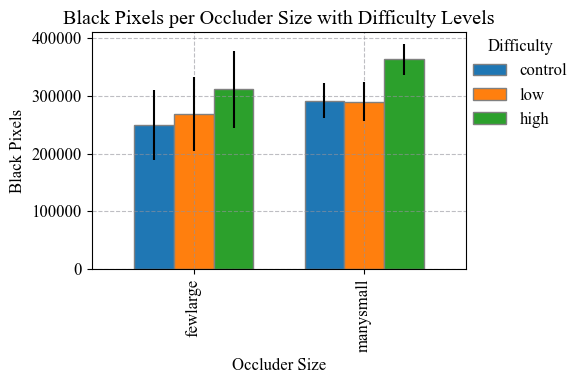

In [ ]:
### Pixel count analyses


# list the input images
occluded_images = glob.glob(r'../Experiment/Stimulus/all_stim/occlusion/partialviewing/*/*/*.png')
object_images = glob.glob(r'../Experiment/Stimulus/objects/*.png')

# extract the directory of the object images
object_dir = r'../Experiment/Stimulus/objects/'

# match each occluded image with its object
matched_images = pd.DataFrame({
    'occluded_images' : [i for i in occluded_images],
    'object_images' : [object_dir + (Path(i).name).split('_')[-1]
                       for i in occluded_images],
    'black pixels' : [(0) for _ in range(len(occluded_images))], # empty column here
    'occluder size' : [(Path(i).name).split('_')[0]
                       for i in occluded_images],
    'difficulty' : [(Path(i).name).split('_')[-2]
                    for i in occluded_images]
})

# loop over all images and calculate black pixels
for i in range(len(occluded_images)): 
    # extract the name of the images
    occluded_file = matched_images['occluded_images'][i]
    object_file = matched_images['object_images'][i]

    # read the images
    occluded_im = cv.imread(occluded_file, -1)
    object_im = cv.imread(object_file, -1)

    # extract the object mask
    object_mask = object_im[:,:,3] == 255

    # remove the object from the count
    im_without_object = occluded_im[~object_mask]

    # count the black pixels
    nb_black_pixels = len(im_without_object[im_without_object == 0])

    # append the results
    matched_images['black pixels'][i] = nb_black_pixels



## Plot the number of black pixels per occluder size

# Group data by 'occluder size' and 'difficulty', calculate mean and standard deviation
grouped_data = matched_images.groupby(['occluder size', 'difficulty'])['black pixels'].agg(['mean', 'std'])
# Pivot table to rearrange data for plotting
pivot_data = grouped_data.reset_index().pivot(index='occluder size', columns='difficulty', values='mean')
# Standard error calculation
pivot_data_err = grouped_data.reset_index().pivot(index='occluder size', columns='difficulty', values='std')
# reorder the columns
pivot_data = pivot_data[['control', 'low', 'high']]
pivot_data_err = pivot_data_err[['control', 'low', 'high']]
# Plotting bar chart with distance and gray outline
ax = pivot_data.plot(kind='bar', yerr=pivot_data_err, figsize=(6, 4), edgecolor='gray', linewidth=1, width=0.7)
plt.title('Black Pixels per Occluder Size with Difficulty Levels')
plt.xlabel('Occluder Size')
plt.ylabel('Black Pixels')
plt.legend(title='Difficulty', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

# add some visualisations here: per level of difficulty, scatterplots of black
# pixels per accuracy with hue on the occluder size

# add your first tests: one linear regression per level of difficulty, with dependent variable
# accuracy and predictor black pixels

# then check, per difficulty level, how accuracy is driven by black pixels (make
# your scatterplots here)


In [ ]:
### Aperture counts

# let's drop this part for now